# [Title Here - last thing to update]

### INTRODUCTION [copy from report - no one needs to spend time on this]

- provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
- clearly state the question you tried to answer with your project
- identify and describe the dataset that was used to answer the question

- we should make sure to explain our choice of predictor variables

### METHODS & RESULTS

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. (AJ Dreher)

- these methods should be added to the report, alongside the relevant code
- we should mention why family relationships and health can be used as quantitative variables because they are measured on a self-report scale, and we are assuming equal distances between the different intervals in the scale

- your report should include code which: (Charul)
 - loads data from the original source on the web **(not from /data folder)**
 - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
 - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
 - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
 - performs the data analysis
 - creates a visualization of the analysis 


*note: all tables and figure should have a figure/table number and a legend*

In [1]:
library(tidyverse)
library(repr)
library(caret)
library(ggplot2)
library(tidymodels)
library (forcats)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9

In [6]:
download.file ("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", "student.zip")

unzip("student.zip")

student_data <- read_delim("student-por.csv", delim = ";")

glimpse (student_data)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



Rows: 649
Columns: 33
$ school     <chr> "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP", "GP"…
$ sex        <chr> "F", "F", "F", "F", "F", "M", "M", "F", "M", "M", "F", "F"…
$ age        <dbl> 18, 17, 15, 15, 16, 16, 16, 17, 15, 15, 15, 15, 15, 15, 15…
$ address    <chr> "U", "U", "U", "U", "U", "U", "U", "U", "U", "U", "U", "U"…
$ famsize    <chr> "GT3", "GT3", "LE3", "GT3", "GT3", "LE3", "LE3", "GT3", "L…
$ Pstatus    <chr> "A", "T", "T", "T", "T", "T", "T", "A", "A", "T", "T", "T"…
$ Medu       <dbl> 4, 1, 1, 4, 3, 4, 2, 4, 3, 3, 4, 2, 4, 4, 2, 4, 4, 3, 3, 4…
$ Fedu       <dbl> 4, 1, 1, 2, 3, 3, 2, 4, 2, 4, 4, 1, 4, 3, 2, 4, 4, 3, 2, 3…
$ Mjob       <chr> "at_home", "at_home", "at_home", "health", "other", "servi…
$ Fjob       <chr> "teacher", "other", "other", "services", "other", "other",…
$ reason     <chr> "course", "course", "other", "home", "home", "reputation",…
$ guardian   <chr> "mother", "father", "mother", "mother", "father", "mother"…
$ traveltime <dbl> 2, 1, 1, 1,

In [8]:
student_data <- student_data %>% 
            select (G3, absences, famrel, health)

student_data %>% head (10)

G3,absences,famrel,health
<dbl>,<dbl>,<dbl>,<dbl>
11,4,4,3
11,2,5,3
12,6,4,3
14,0,3,5
13,0,4,5
13,6,5,5
13,0,4,3
13,2,4,1
17,0,4,1


In [9]:
set.seed (1)

student_split <- initial_split(student_data, prop = 0.7, strata = G3)
student_train <- training(student_split)
student_test <- testing(student_split)

In [10]:
# In this table, we summarized the mean, minimum and maximum final grades of students on the basis of number of absences

absences_summary <- group_by (student_train, absences) %>% 
            summarize (
                min_final_grade = min(G3), 
                max_final_grade = max (G3), 
                mean_final_grade = mean (G3)
                )
absences_summary

`summarise()` ungrouping output (override with `.groups` argument)



absences,min_final_grade,max_final_grade,mean_final_grade
<dbl>,<dbl>,<dbl>,<dbl>
0,0,19,12.142012
1,10,16,12.500000
2,7,18,12.306667
3,7,17,11.000000
4,6,19,11.865672
5,8,17,11.750000
6,8,17,12.303030
7,8,16,13.000000
8,7,15,11.586207


In [12]:
# In this table, we summarized the mean, minimum and maximum final grades of students on the basis of quality of family relationships (numeric: from 1 - very bad to 5 - excellent)

famrel_summary <- group_by (student_train, famrel) %>% 
            summarize (
                min_final_grade = min(G3), 
                max_final_grade = max (G3), 
                mean_final_grade = mean (G3)
                )
famrel_summary

`summarise()` ungrouping output (override with `.groups` argument)



famrel,min_final_grade,max_final_grade,mean_final_grade
<dbl>,<dbl>,<dbl>,<dbl>
1,0,15,9.090909
2,0,15,10.352941
3,0,19,11.573333
4,0,18,12.432432
5,0,18,11.770992


In [13]:
# In this table, we summarized the mean, minimum and maximum final grades of students on the basis of current health status (numeric: from 1 - very bad to 5 - very good)

health_summary <- group_by (student_train, health) %>% 
            summarize (
                min_final_grade = min(G3), 
                max_final_grade = max (G3), 
                mean_final_grade = mean (G3)
                )
health_summary

`summarise()` ungrouping output (override with `.groups` argument)



health,min_final_grade,max_final_grade,mean_final_grade
<dbl>,<dbl>,<dbl>,<dbl>
1,0,18,12.66129
2,0,19,12.44828
3,0,19,11.82143
4,0,18,12.08108
5,0,18,11.52809


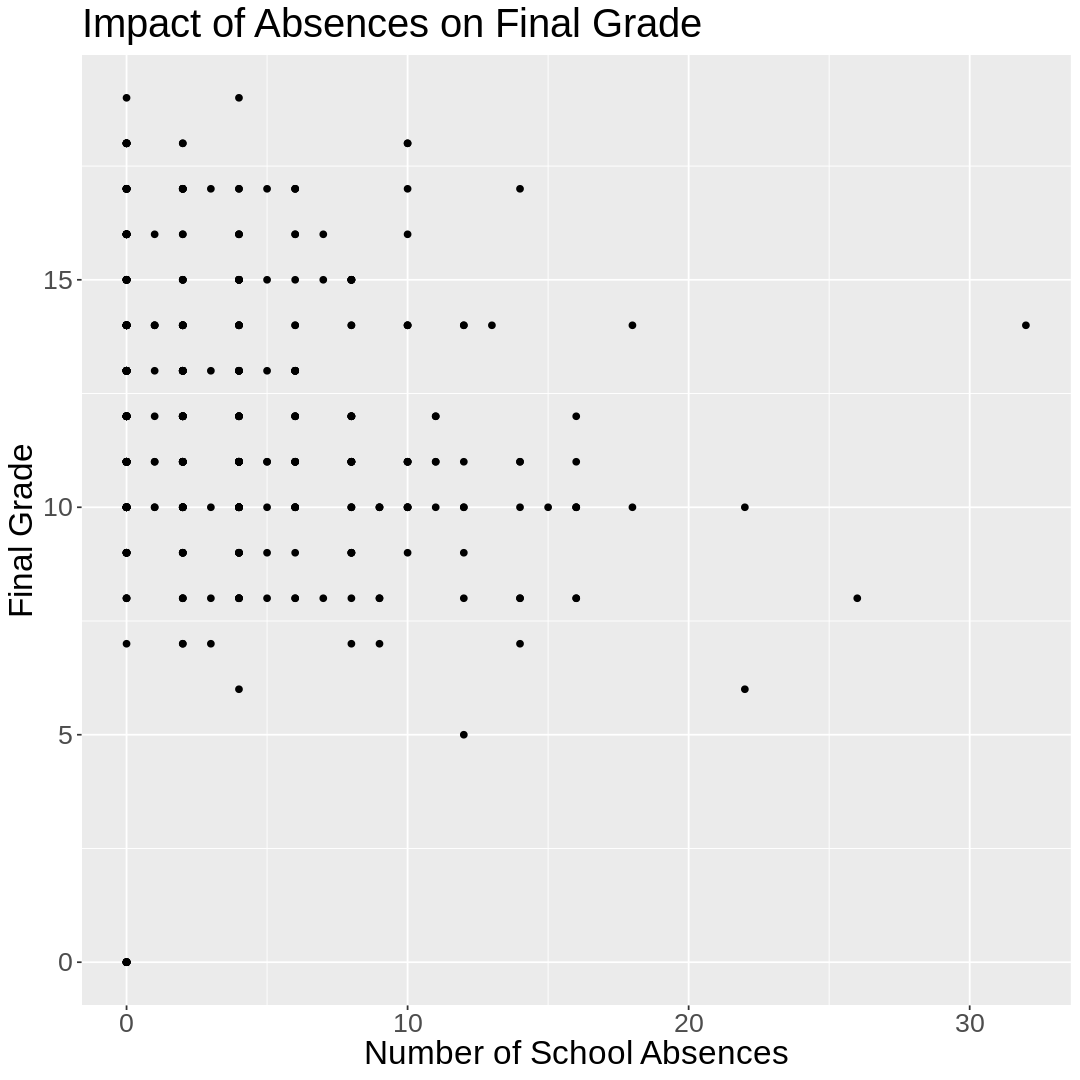

In [14]:
options(repr.plot.width = 9, repr.plot.height = 9)

absences_plot <- ggplot(student_train, aes(x = absences, y = G3)) + 
  geom_point() + 
  xlab("Number of School Absences") +
  ylab("Final Grade") + 
    labs (title = "Impact of Absences on Final Grade") +
theme(text = element_text(size=20)) 

absences_plot

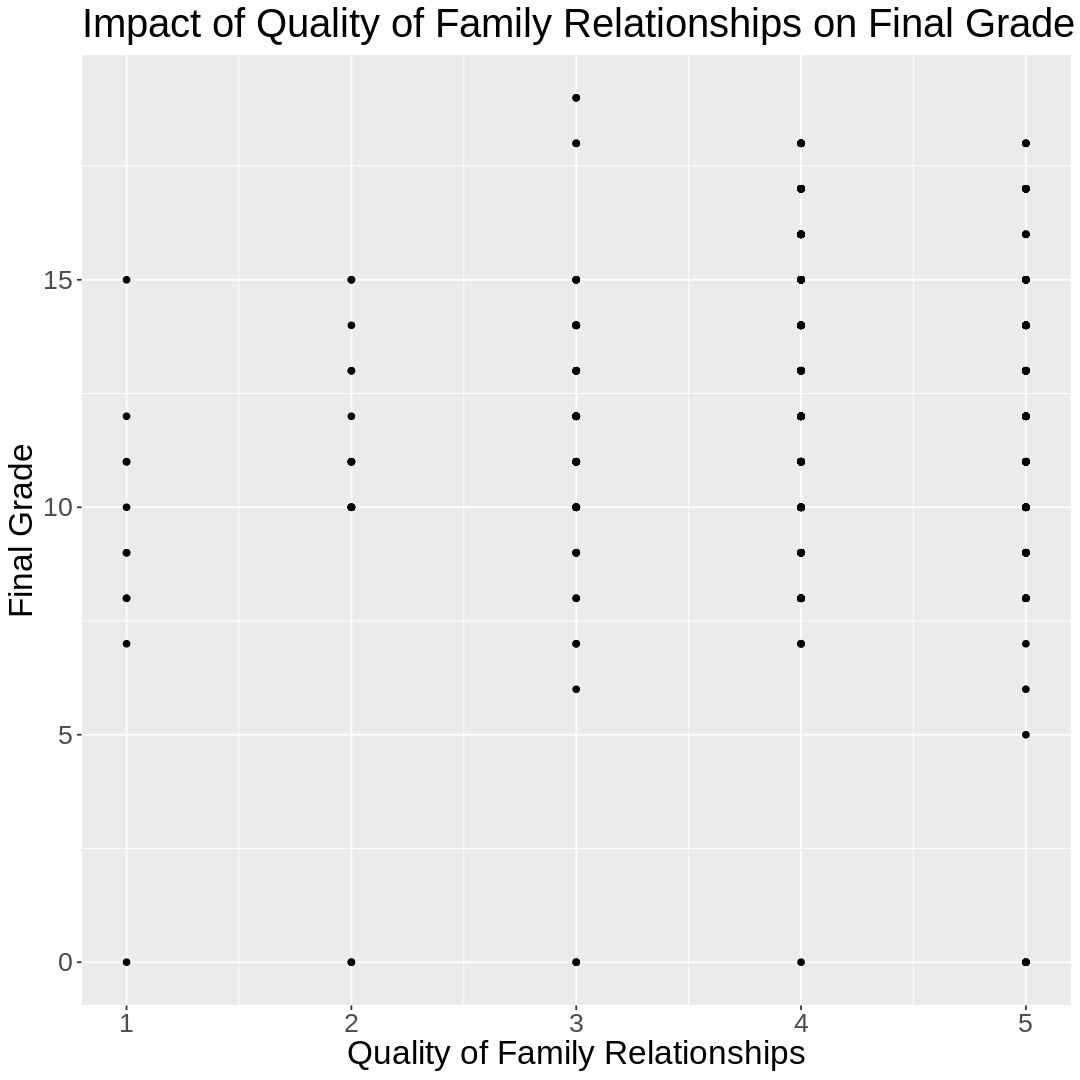

In [15]:
famrel_plot <- ggplot(student_train, aes(x = famrel, y = G3)) + 
  geom_point() + 
  xlab("Quality of Family Relationships") +
  ylab("Final Grade") + 
    labs (title = "Impact of Quality of Family Relationships on Final Grade") +
theme(text = element_text(size=20)) 

famrel_plot

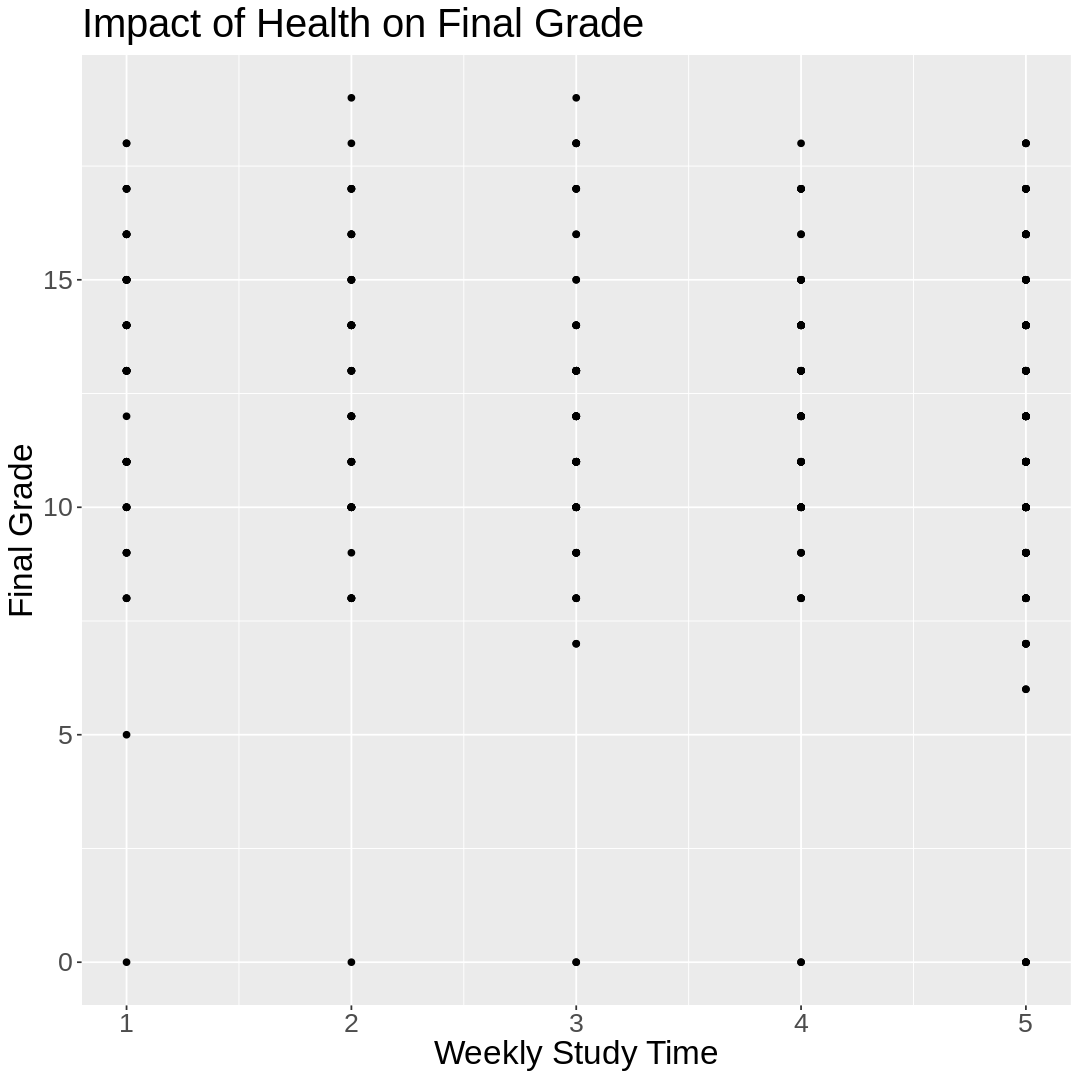

In [16]:
health_plot <- ggplot(student_train, aes(x = health, y = G3)) + 
  geom_point() + 
  xlab("Weekly Study Time") +
  ylab("Final Grade") + 
    labs (title = "Impact of Health on Final Grade") +
theme(text = element_text(size=20)) 

health_plot

In [17]:
#k-nn regression with first predictor, absences

student_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("regression")

absences_recipe <- recipe(G3 ~ absences, data = student_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

student_vfold <- vfold_cv(student_train, v = 5, strata = G3)

absences_wkflw <- workflow() %>%
  add_recipe(absences_recipe) %>%
  add_model(student_spec)

In [18]:
gridvals <- tibble(neighbors = seq(1, 200))

absences_results <- absences_wkflw %>%
  tune_grid(resamples = student_vfold, grid = gridvals) %>%
  collect_metrics()

absences_min <- absences_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean))
absences_min

#this indicates k with the lowest rmse on the basis of cross-validation and tuning

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
29,rmse,standard,3.227304,5,0.245183,Model029


In [19]:
absences_kmin <- absences_min %>% pull(neighbors)

absences_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = absences_kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

absences_fit <- workflow() %>%
  add_recipe(absences_recipe) %>%
  add_model(absences_spec) %>%
  fit(data = student_train)

absences_summary <- absences_fit %>%
  predict(student_test) %>%
  bind_cols(student_test) %>%
  metrics(truth = G3, estimate = .pred)
absences_summary

# rmspe with testing data, with chosen k

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.1787065398
rsq,standard,0.0008774348
mae,standard,2.3367875648


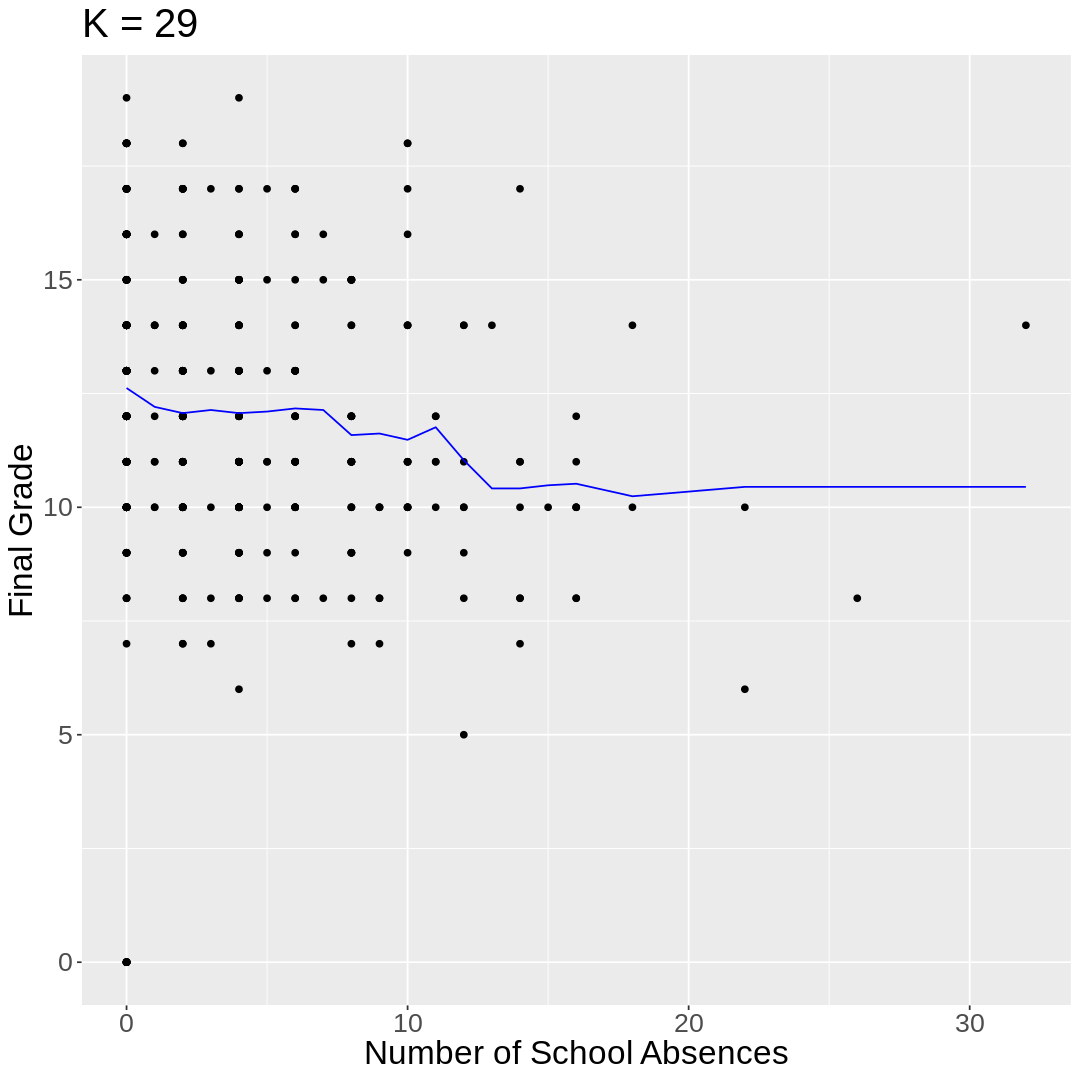

In [20]:
absences_preds <- absences_fit %>%
  predict(student_train) %>%
  bind_cols(student_train)

absences_plot <- ggplot(absences_preds, aes(x = absences, y = G3)) +
  geom_point() +
  xlab("Number of School Absences") +
  ylab("Final Grade") +
  geom_line(data = absences_preds, aes(x = absences, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", absences_kmin)) +
theme(text = element_text(size=20)) 

absences_plot

# scatterplot with k-nn regression line

In [21]:
# repeat of k-nn regression analysis with second predictor, quality of family relationships

famrel_recipe <- recipe(G3 ~ famrel, data = student_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

famrel_wkflw <- workflow() %>%
  add_recipe(famrel_recipe) %>%
  add_model(student_spec)

In [22]:
gridvals <- tibble(neighbors = seq(1, 200))

famrel_results <- famrel_wkflw %>%
  tune_grid(resamples = student_vfold, grid = gridvals) %>%
  collect_metrics()

famrel_min <- famrel_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean))
famrel_min


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
91,rmse,standard,3.203234,5,0.2237975,Model091


In [23]:
famrel_kmin <- famrel_min %>% pull(neighbors)

famrel_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = famrel_kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

famrel_fit <- workflow() %>%
  add_recipe(famrel_recipe) %>%
  add_model(famrel_spec) %>%
  fit(data = student_train)

famrel_summary <- famrel_fit %>%
  predict(student_test) %>%
  bind_cols(student_test) %>%
  metrics(truth = G3, estimate = .pred)
famrel_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.18103110
rsq,standard,0.00239548
mae,standard,2.34732107


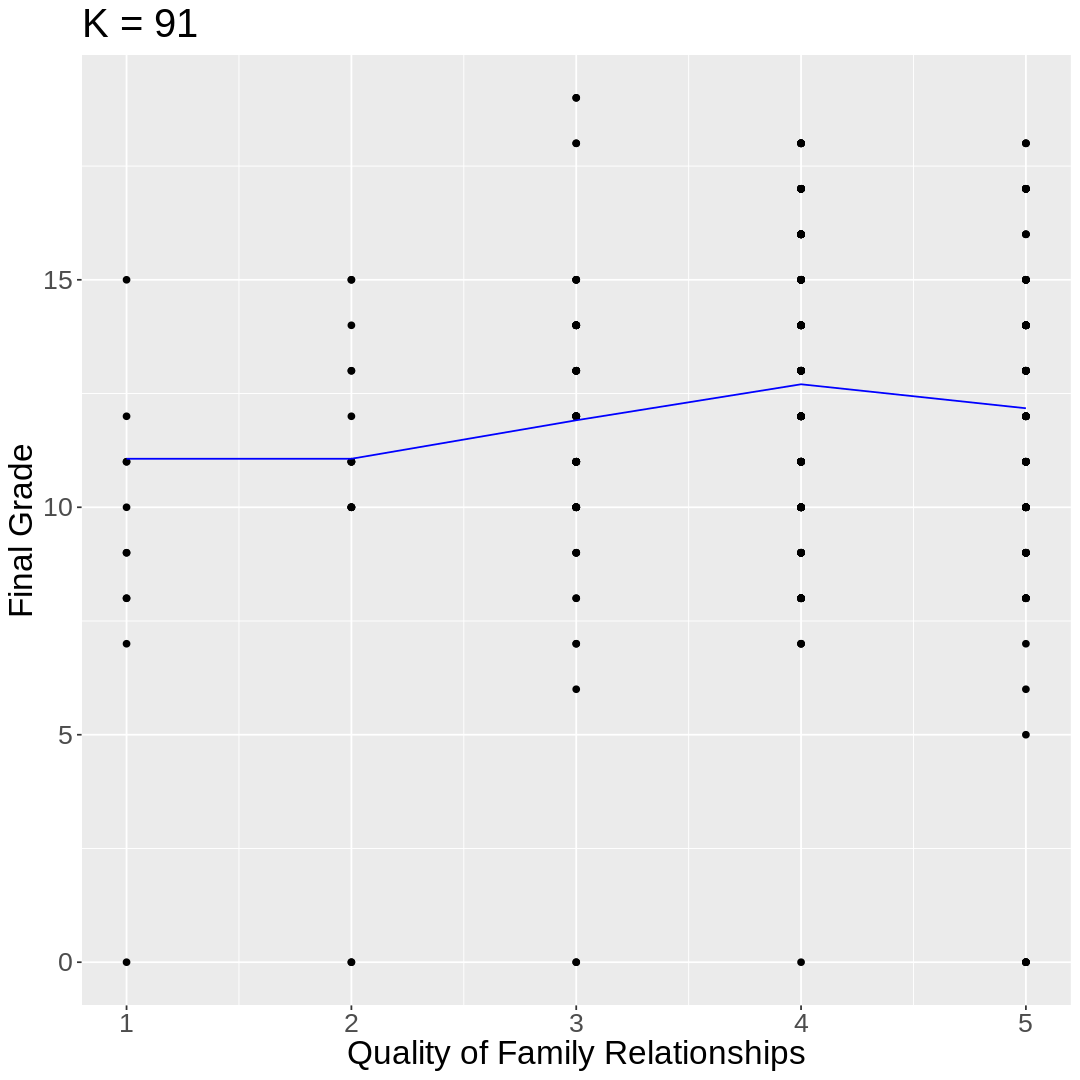

In [24]:
famrel_preds <- famrel_fit %>%
  predict(student_train) %>%
  bind_cols(student_train)

famrel_plot <- ggplot(famrel_preds, aes(x = famrel, y = G3)) +
  geom_point() +
  xlab("Quality of Family Relationships") +
  ylab("Final Grade") +
  geom_line(data = famrel_preds, aes(x = famrel, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", famrel_kmin)) +
theme(text = element_text(size=20)) 
famrel_plot

In [25]:
# repeat of k-nn analysis with third predictor, health

health_recipe <- recipe(G3 ~ health, data = student_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

health_wkflw <- workflow() %>%
  add_recipe(health_recipe) %>%
  add_model(student_spec)

In [26]:
gridvals <- tibble(neighbors = seq(1, 200))

health_results <- health_wkflw %>%
  tune_grid(resamples = student_vfold, grid = gridvals) %>%
  collect_metrics()

health_min <- health_results %>%
  filter(.metric == "rmse") %>%
  filter(mean == min(mean))
health_min


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
114,rmse,standard,3.227498,5,0.2356295,Model114


In [27]:
health_kmin <- health_min %>% pull(neighbors)

health_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = health_kmin) %>%
  set_engine("kknn") %>%
  set_mode("regression")

health_fit <- workflow() %>%
  add_recipe(health_recipe) %>%
  add_model(health_spec) %>%
  fit(data = student_train)

health_summary <- health_fit %>%
  predict(student_test) %>%
  bind_cols(student_test) %>%
  metrics(truth = G3, estimate = .pred)
health_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.130846181
rsq,standard,0.004066698
mae,standard,2.327379329


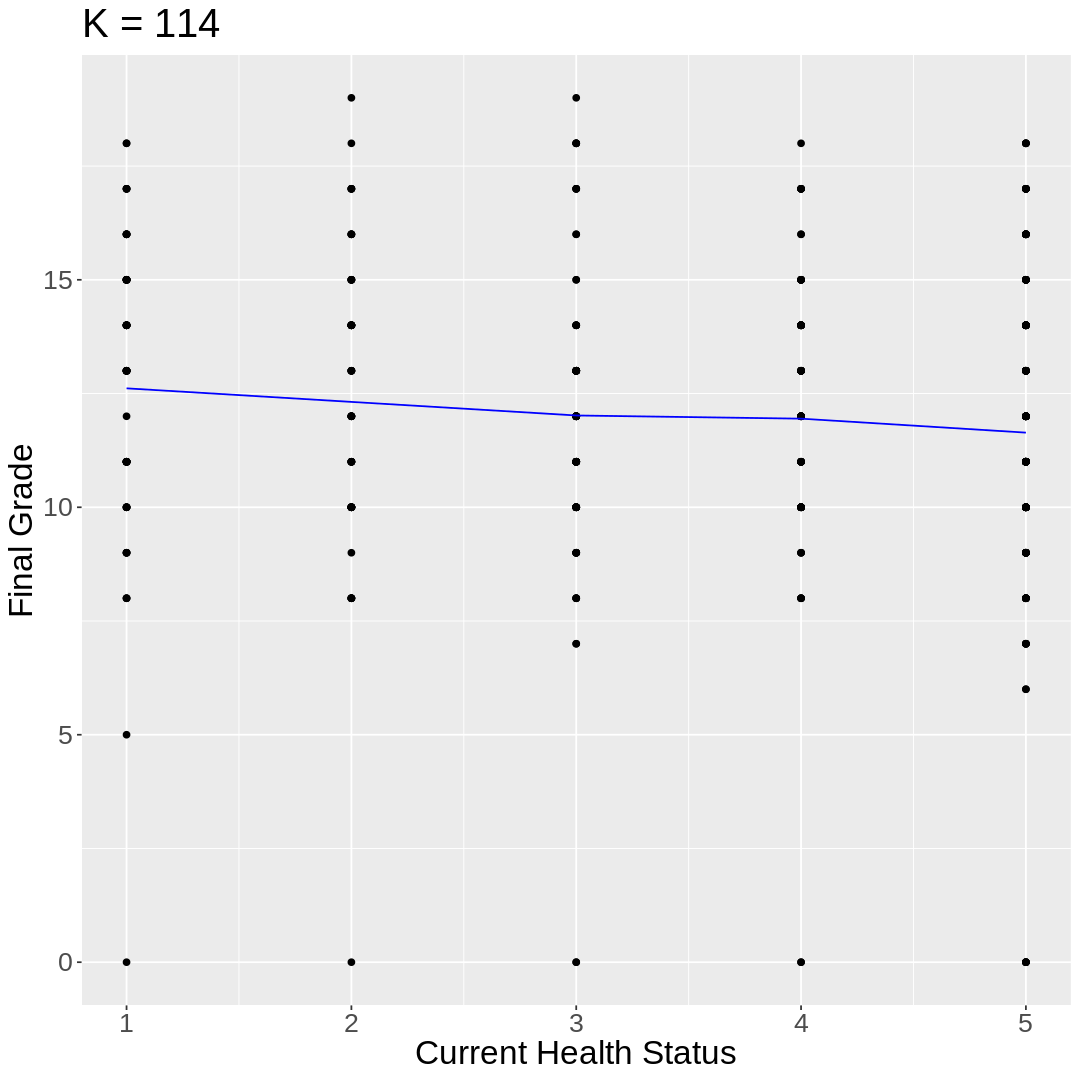

In [28]:
health_preds <- health_fit %>%
  predict(student_train) %>%
  bind_cols(student_train)

health_plot <- ggplot(health_preds, aes(x = health, y = G3)) +
  geom_point() +
  xlab("Current Health Status") +
  ylab("Final Grade") +
  geom_line(data = health_preds, aes(x = health, y = .pred), color = "blue") +
  ggtitle(paste0("K = ", health_kmin)) +
theme(text = element_text(size=20)) 
health_plot

## Discussion (Avery)
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

Some notes for the discussion: 
- you can mention that the inital exploratory analysis (tables as well as scatterplots) do not seem to indicate a clear relationship between predictors and target variables 
- how all of the predictors have a similar RMSPE, but it is difficult to judge this RMSPE of around 3, because it depends on the scale of the target variable 
- how the high k values could indicate overfitting of the models (low variance and high bias) - look at notes in textbook on this section, and discuss advantages/limitations to having chosen the k-nn regression model for this analysis (perhaps mention how future analysis can use different models, and what the advantages of that could be). 
- while quality of family relationships cannot be directly manipulated, if shown to have an important effect on students' ability to learn, then education facilities should take into account/be sensitive of how students could be mentally impacted by bad family relationships, and attempt to offer support in order to offset this


### References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references)
- Make sure to cite the source of your data as well

This is the citation for the source: P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

https://archive.ics.uci.edu/ml/datasets/Student+Performance


**Potential sources:**
- https://inservice.ascd.org/exploring-learning-and-health-what-influences-a-childs-ability-to-learn/
- https://www.education.vic.gov.au/school/teachers/teachingresources/Pages/identifying-high-ability-students.aspx
- https://www.oecd.org/site/educeri21st/40600533.pdf (good source)
- https://owlcation.com/academia/Factors-that-affect-Student-Learning